In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, sosfiltfilt, welch
import pandas as pd
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA


In [28]:
# load data

# sampling frequency from paper
fs = 2000
ninapro_root = "./Ninapro/DB1"
print(os.path.abspath(ninapro_root))

ex1_file = os.path.join(ninapro_root, "S2_A1_E1.mat")

data = loadmat(ex1_file)

# Inspect available keys
print(data.keys())

# Ninapro EMG data is stored under key 'emg'
emg = data['emg']

data_shape = emg.shape
n_timepoints = emg.shape[0]
n_channels = emg.shape[1]

print(f'The shape of the data is {data_shape}')
print(f'There are {n_timepoints} timepoints')
print(f'There are {n_channels} channels')
#each channel = a single EMG electrode on the participant


/Users/colineleteurtre/Desktop/cours/NSSP/NSSP_project2_groupK/Ninapro/DB1


dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])
The shape of the data is (100686, 10)
There are 100686 timepoints
There are 10 channels


## 1) Visualization and Preprocessing

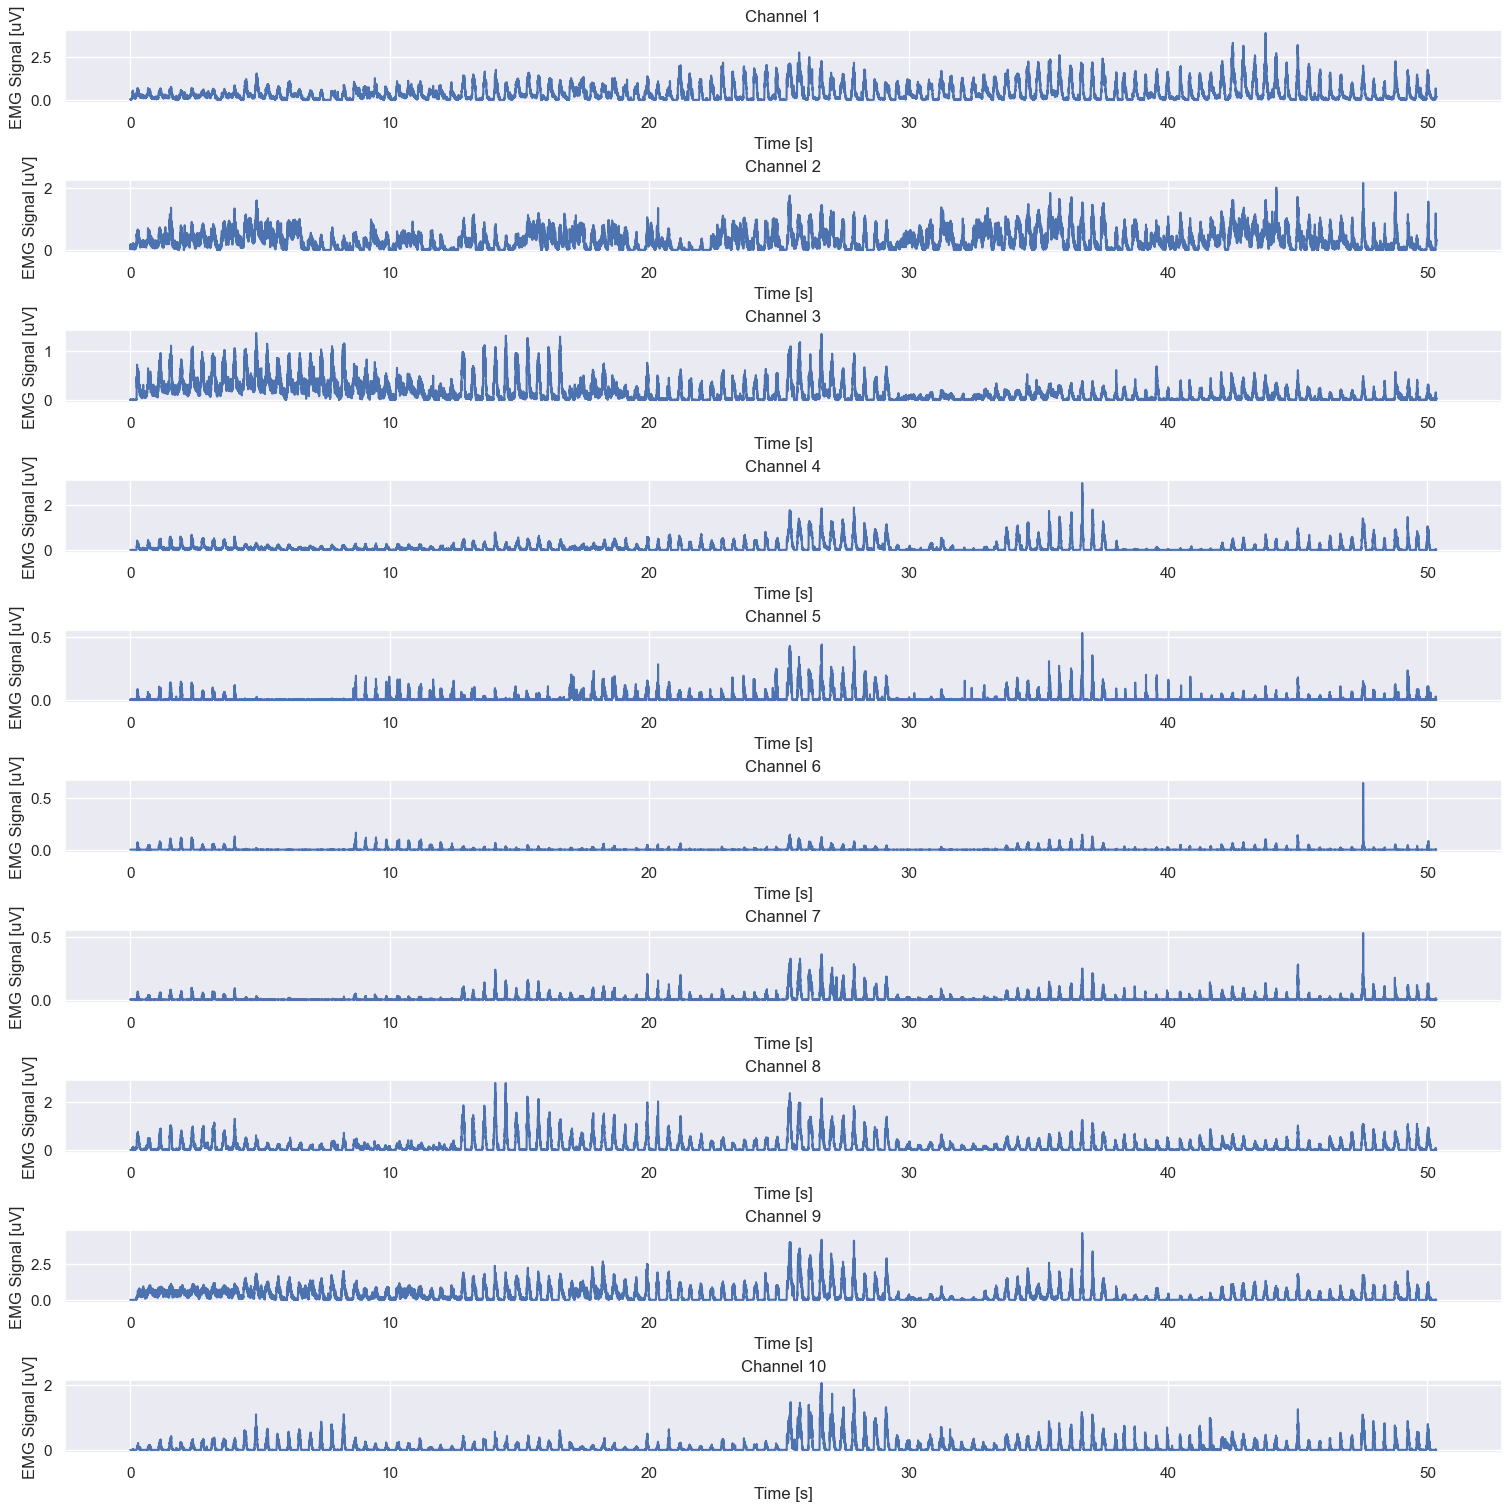

In [29]:
# visualize signals
n_channels = emg.shape[1]

#Time vector for plotting : create evenly spaced time bins from 0 to the total duration of the signal in s
time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}") #channel number
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")

In [30]:
# data is already partly preprocessed !!! Means it's already the absolute value that is taken
emg_rectified = data["emg"].copy()

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 

#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


In [31]:
#just for vizualization purposes !! Not asked 

# Randomly select 10 indices without replacement
random_indices = np.random.choice(emg.shape[0], size=10, replace=False)

# Extract the EMG, stimulus, and repetition for those indices
emg_random = emg[random_indices, :]
stimulus_random = stimulus[random_indices, 0]
repetition_random = repetition[random_indices, 0]

# Combine into a DataFrame
df_random = pd.DataFrame(emg_random, columns=[f"Ch{c+1}" for c in range(emg.shape[1])])
df_random["Stimulus"] = stimulus_random
df_random["Repetition"] = repetition_random

print(df_random)

      Ch1     Ch2     Ch3     Ch4     Ch5     Ch6     Ch7     Ch8     Ch9  \
0  0.2441  0.2759  0.2588  0.0537  0.0024  0.0024  0.0024  0.2051  0.5811   
1  0.2344  0.3735  0.0366  0.0659  0.0049  0.0024  0.0024  0.0366  0.0220   
2  0.0220  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024   
3  1.2939  0.6494  0.3589  0.7324  0.1538  0.0317  0.1099  0.7202  1.8188   
4  0.5640  0.4175  0.1245  0.0464  0.0024  0.0024  0.0024  0.1099  0.4053   
5  0.2246  0.6860  0.1001  0.0073  0.0024  0.0024  0.0024  0.0171  0.0024   
6  0.0903  0.1538  0.0195  0.0366  0.0024  0.0024  0.0024  0.0024  0.0293   
7  0.2173  0.0439  0.1904  0.0073  0.0024  0.0024  0.0024  0.1733  0.1270   
8  0.0317  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024   
9  0.1514  0.5835  0.1147  0.0244  0.0024  0.0024  0.0024  0.0049  0.0098   

     Ch10  Stimulus  Repetition  
0  0.0513         0           0  
1  0.0146         8           4  
2  0.0024         0           0  
3  0.6104       

In [32]:
# data is already partly preprocessed !!! Means it's already the absolute value that is taken
emg_rectified = data["emg"].copy()

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 

#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


In [33]:
# Count stimuli and repetitions


# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') #number of different movemement repeated by the subject, according to them movie (Stimulus) that's why np.unique
print(f'How many repetitions are there? {n_repetitions}')  #if subject repeats mvmt 10 times n_repetition = 10

How many types of movement are there? 12
How many repetitions are there? 10


In [34]:
# different number of samples for different trials
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1) 
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial
# logical we have a matrix of 12 x 10 because combination of 12 stimuli with 10 repetitions = 120 different possibilites 
# so it means 1 trial is a combination of 1 stimuli and 1 repetition

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

In [35]:
#trial length = count of timepoints labeled as perforimg the movement stimulus x in repetition y
# trial = the number of consecutives timepoits where the label pair appears

# the full EMG is 50 sec =100k timepoints because many mvmts, rest, transitions...

In [36]:
# visualize a single trial
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

Text(0.5, 0.98, 'Envelopes of the EMG signal')

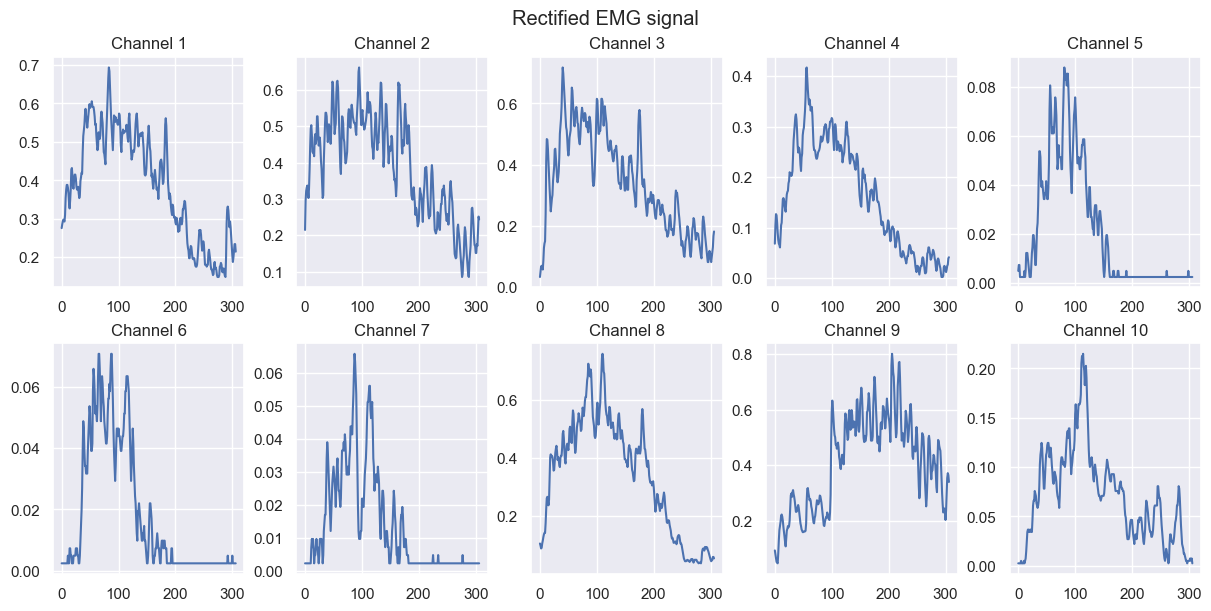

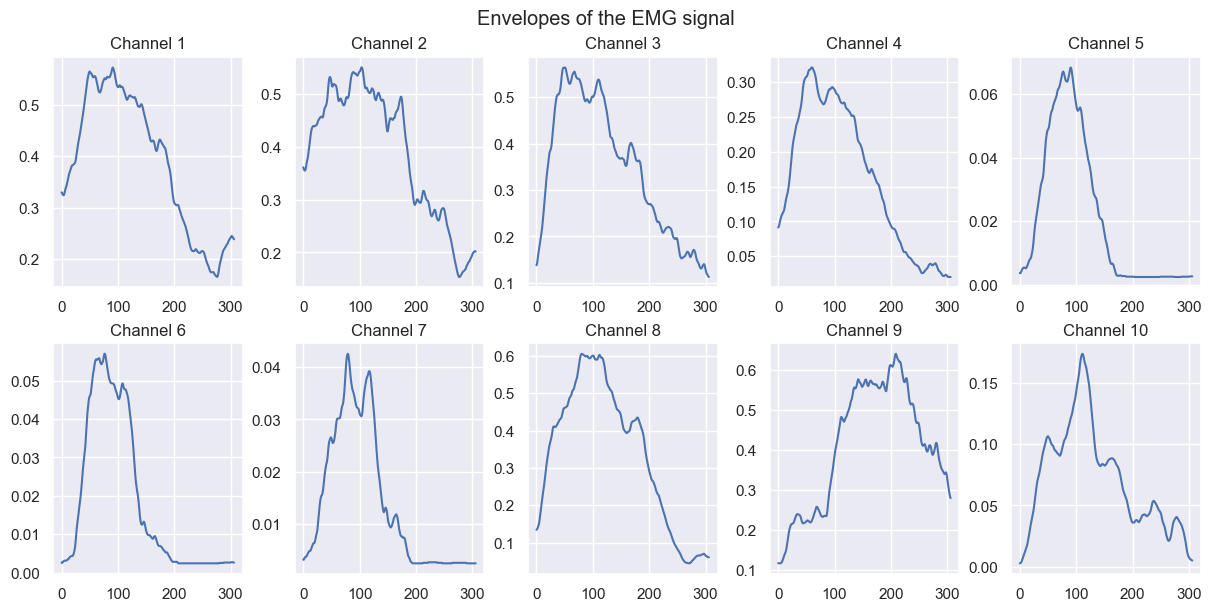

In [37]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

#10 EMG channels
number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx]) # 300 because emg_windows of first trial is 307
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Text(0.5, 0.98, 'Envelopes of the EMG signal')

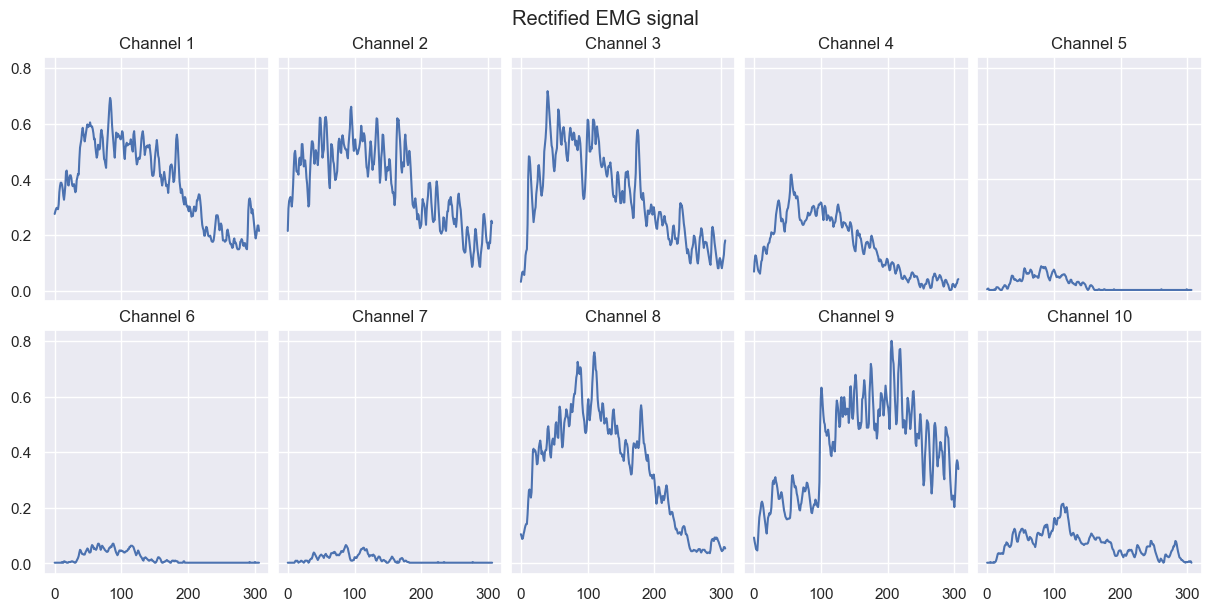

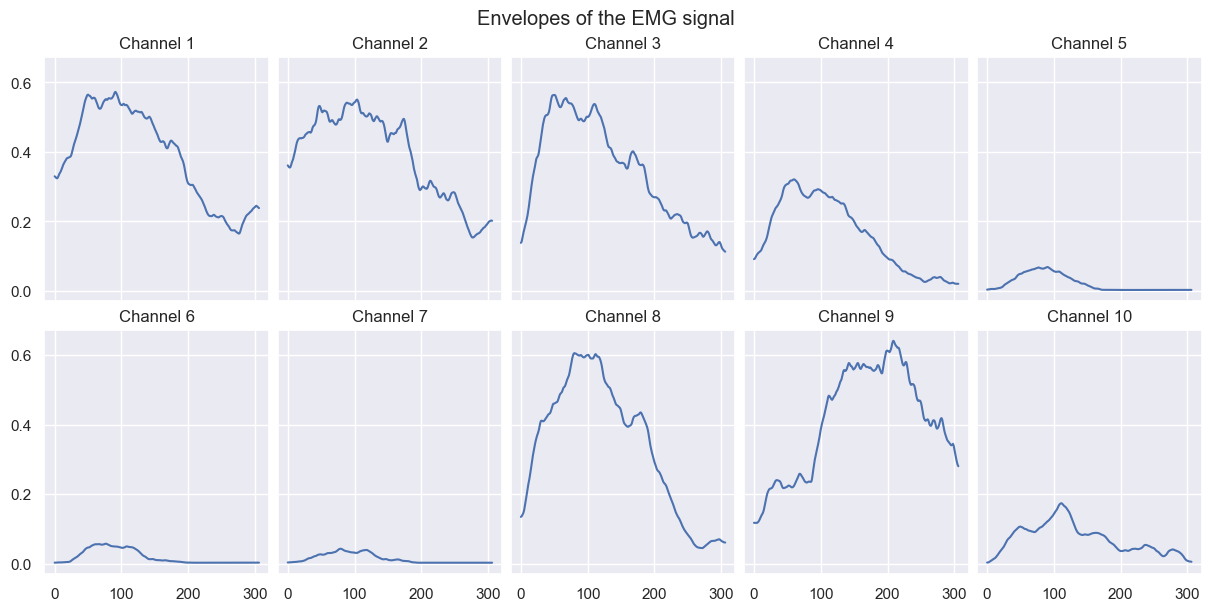

In [38]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

In [39]:
# this was for 1 trial, so a type of repetition and a type of stimulus.

In [40]:
# instead of just one trial, look at all of them 
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

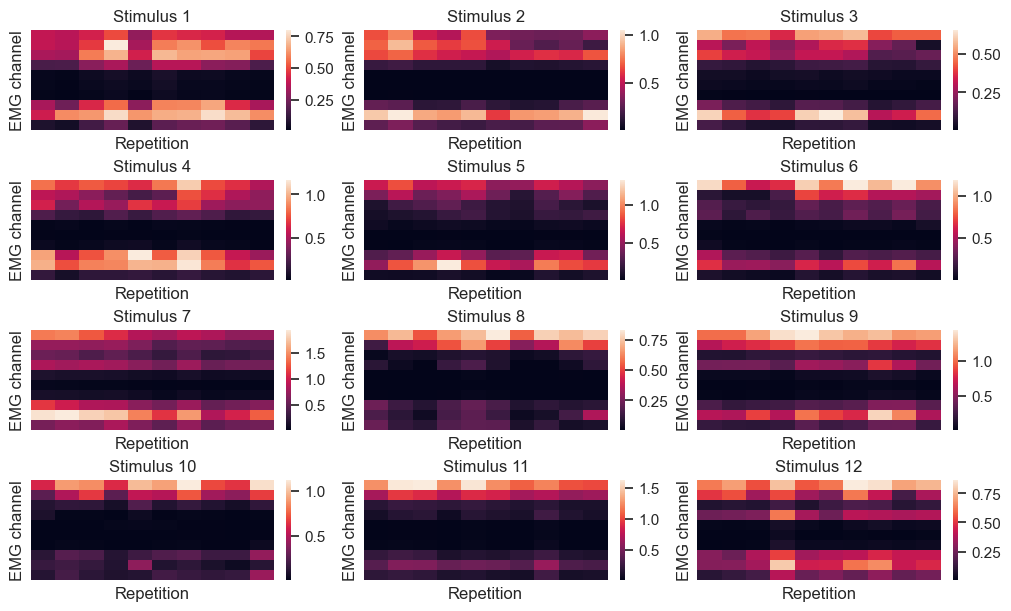

In [41]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

Does the data look reasonable? Did you need to remove any trials?

if one trial failed, we would expect a column where each element is different from its own row.

## 2) Split data and extract features

In [42]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [43]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis = 0) 
# Maximum absolute Value (MAV)
maxav = lambda x: np.max(np.abs(x), axis=0) 
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum(((x[1:-1] - x[:-2]) * (x[1:-1] - x[2:]) > 0),axis=0)

dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc]
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

dataset dimension: (120, 60)
labels dimension: (120,)


In [44]:
# split data, 70% train 15 and 15% val and test

X_train, X_temp, y_train, y_temp = train_test_split(dataset, labels, test_size=0.3, stratify = labels)
# X_temp = 0.3 than later splittend in 50/50 so X_val = X_test = 1/2 * 30% = 15%

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify = y_temp)

In [45]:
# visualize the typical values of the features among the different trials
feature_names = ['MAV','STD','MaxAV','RMS','WL','SSC']
n_features = len(feature_names)

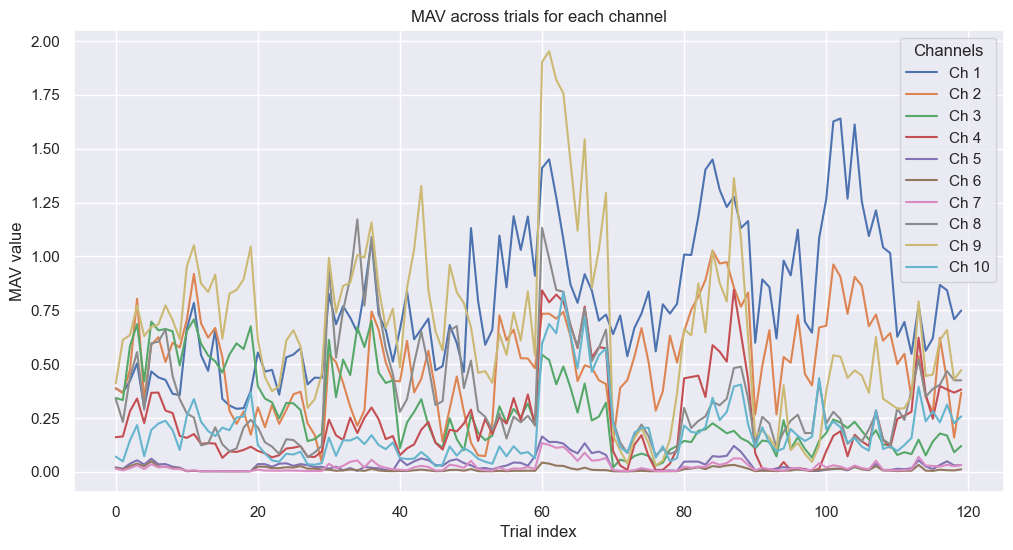

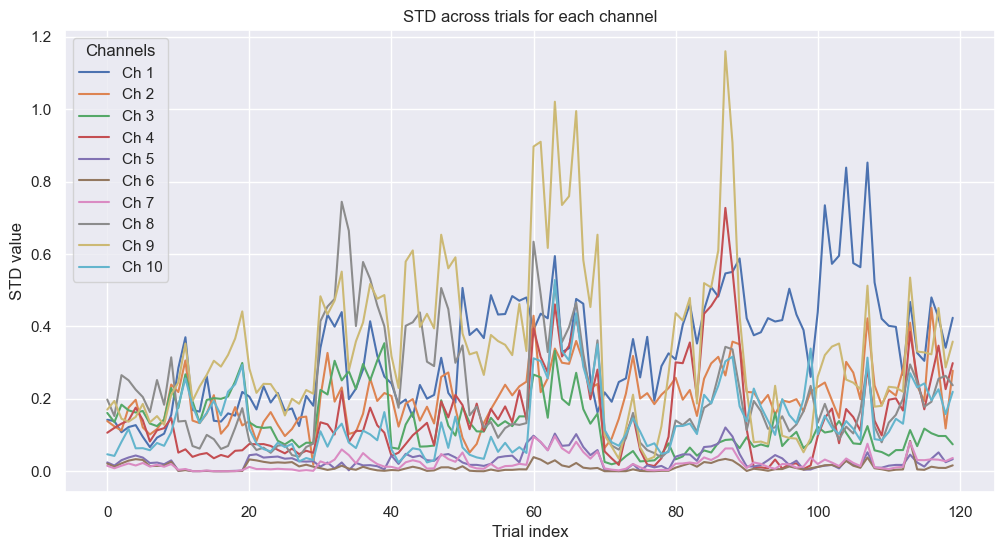

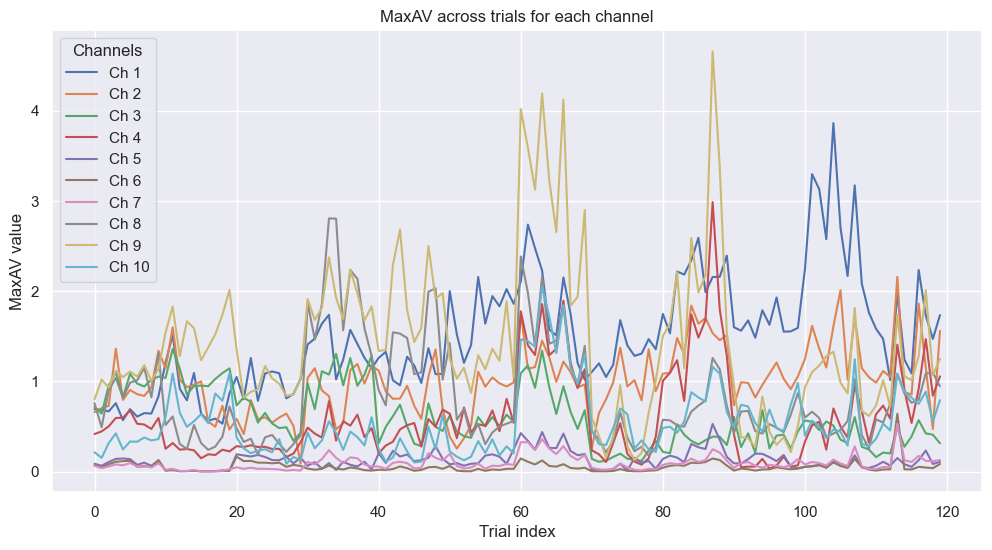

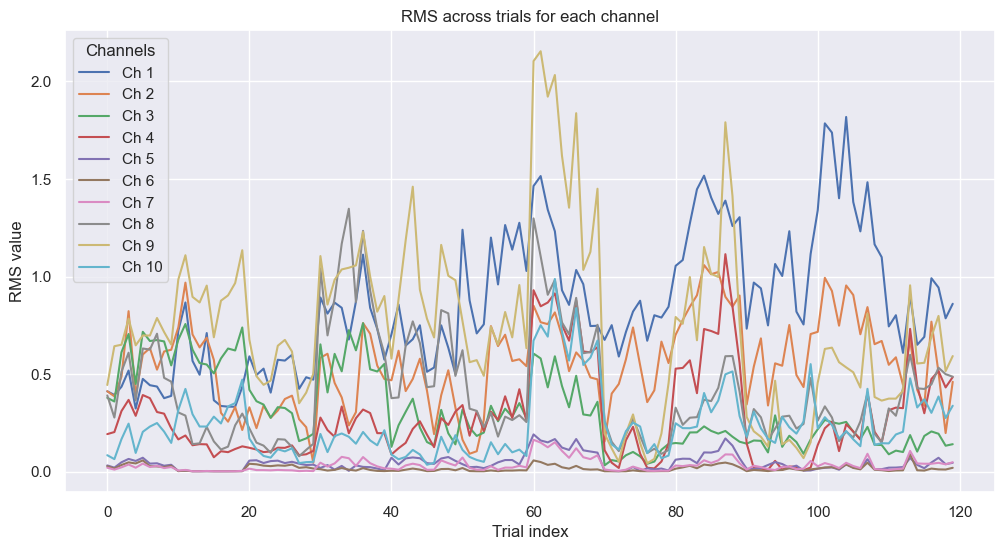

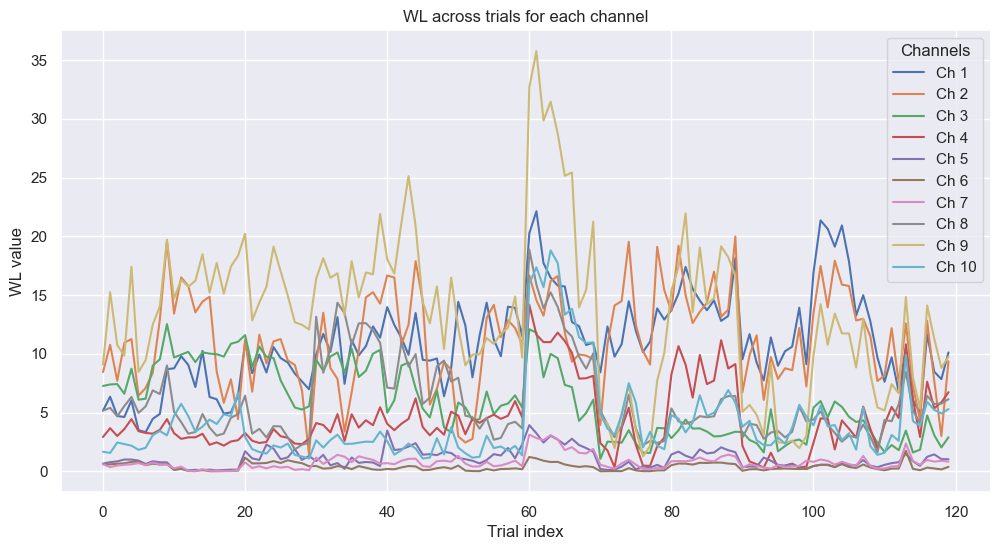

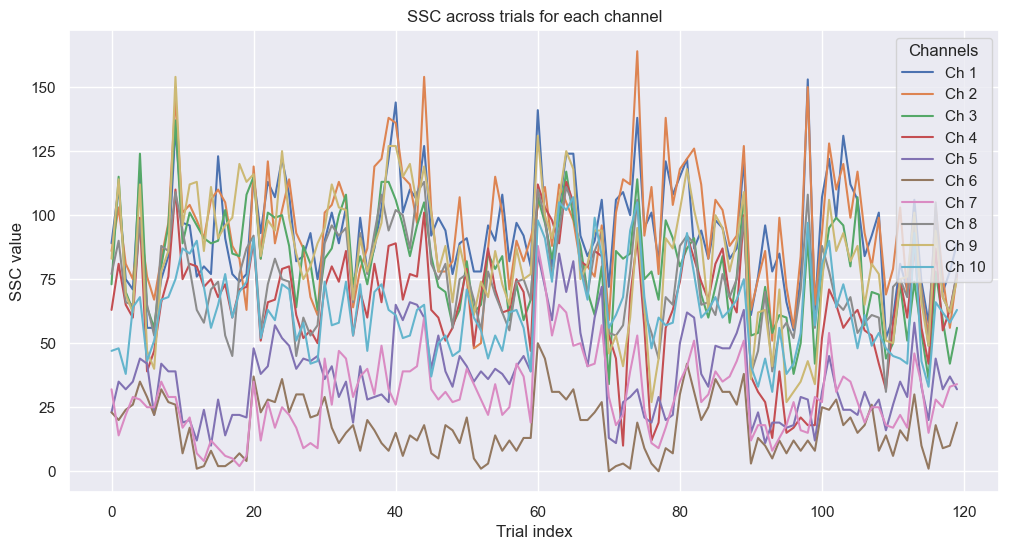

In [46]:
# Plot feature values for all channels for first feature (MAV)
for k in range (n_features):
    plt.figure(figsize=(12,6))
    for ch in range(n_channels):
        plt.plot(dataset[:,ch + n_repetitions*k], label=f"Ch {ch+1}")
    plt.xlabel("Trial index")
    plt.ylabel(f"{feature_names[k]} value")
    plt.title(f"{feature_names[k]} across trials for each channel")
    plt.legend(title = 'Channels')
    plt.show()

## 3) Classification

In [47]:
# first just baseline model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

print("Baseline accuracy:", rf.score(X_val, y_val))

Baseline accuracy: 0.7777777777777778


In [48]:
# now hyperparameter optimization to find best model
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross validation
    scoring="accuracy",   # optimize accuracy
    n_jobs=-1,            # use all cores
    verbose=1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV accuracy: 0.9154411764705882


In [49]:
best_rf = grid.best_estimator_

val_acc = best_rf.score(X_val, y_val)
test_acc = best_rf.score(X_test, y_test)

print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)


Validation accuracy: 0.8888888888888888
Test accuracy: 0.9444444444444444


In [50]:
# metrics F1 or accuracy ?
y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1-score:", f1_score(y_test, y_pred, average='macro'))


Accuracy: 0.9444444444444444
Macro F1-score: 0.8888888888888888


## 4) Feature selection

Estimated mutual information between each feature and the target:
[0.69281789 0.45611348 0.75412595 1.01529793 0.80940025 0.52207202
 0.70712573 0.67490689 0.84201006 0.72423484 0.78973073 0.32804674
 0.61484938 0.88905452 0.62682284 0.46347246 0.64238529 0.68977512
 0.9138104  0.56476097 0.85379658 0.45905948 0.64985051 0.89733206
 0.63201488 0.45193084 0.52507673 0.64073474 0.79923172 0.68912206
 0.76542655 0.48658459 0.8407939  0.96224005 0.74491598 0.51127974
 0.66807754 0.71669515 0.88911405 0.66891883 0.63061296 0.06949028
 0.62896855 0.95601213 0.82921276 0.71044477 0.68594946 0.59664356
 0.71176163 0.6104557  0.10364743 0.         0.08934004 0.40790419
 0.59577755 0.51248987 0.56541639 0.24629354 0.22898142 0.29173989]

Macro-F1 score with mutual information feature selection: 0.7222222222222222


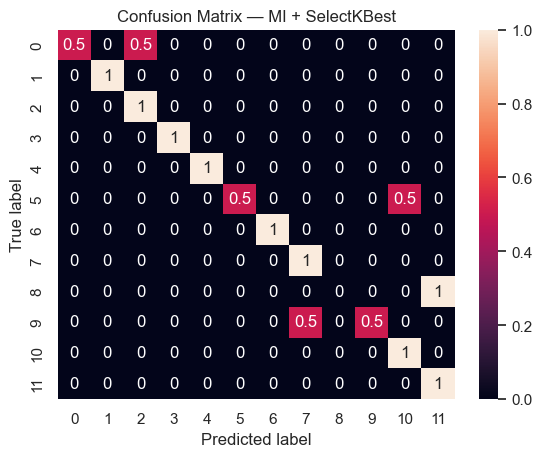

In [53]:
# method 1: mutual info + select K best like in lab

# Calculate mutual information between each feature and the target variable
mutual_info = mutual_info_classif(X_train, y_train)
print(f"Estimated mutual information between each feature and the target:\n{mutual_info}\n")

# Select the top 3 features based on mutual information scores
k_best = SelectKBest(mutual_info_classif, k=30)
k_best.fit(X_train, y_train)

# Transform the datasets to only include the selected features
X_train_best = k_best.transform(X_train)
X_test_best = k_best.transform(X_test)

# Train a Random Forest using the best parameters from GridSearch
clf = RandomForestClassifier(**grid.best_params_, random_state=42)
clf.fit(X_train_best, y_train)

# Predict labels for the test set.
y_pred = clf.predict(X_test_best)

# Evaluate performance: macro F1 score.
f1_mi = f1_score(y_test, y_pred, average="macro")
print(f"Macro-F1 score with mutual information feature selection: {f1_mi}")

# Confusion matrix.
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix — MI + SelectKBest")
plt.show()


PCA reduced dimensionality from 60 to 8 components
Macro-F1 score with PCA: 0.36666666666666664


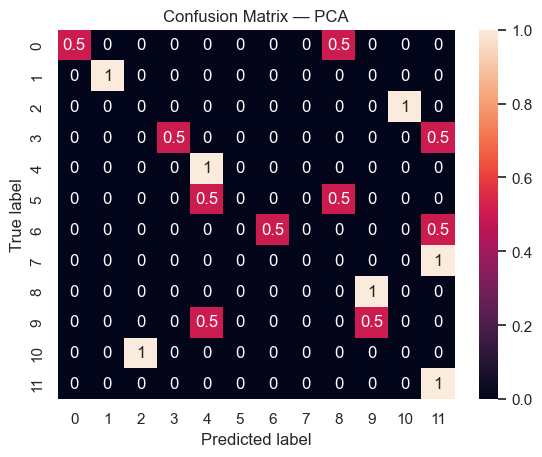

In [54]:
# method 2 : PCA 

# Keep enough components to explain ~95% variance
pca = PCA(n_components=0.95)  
pca.fit(X_train)

# Transform the data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"PCA reduced dimensionality from {X_train.shape[1]} to {X_train_pca.shape[1]} components")

# Train Random Forest using PCA features.
clf_pca = RandomForestClassifier(**grid.best_params_)
clf_pca.fit(X_train_pca, y_train)

# Predict labels.
y_pred_pca = clf_pca.predict(X_test_pca)

# Evaluate performance.
f1_pca = f1_score(y_test, y_pred_pca, average="macro")
print(f"Macro-F1 score with PCA: {f1_pca}")

# Confusion matrix.
confmat2 = confusion_matrix(y_test, y_pred_pca, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat2, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix — PCA")
plt.show()
